# Принятие решений в бизнесе на основе данных

В крупном интренет-магазине необходимо приоритизировать список гипотез для увеличения выручки, запустить A/B-тест и проанализировать результаты. Данные для приоретизации включают в себя краткое описание гипотез и параметры. Данные для анализа A/B-теста получены за август 2019 года и включают в себя данные о продажах и посещениях сайта.


Приоритизация выполнена фреймворками ICE и RICE.

Анализ A/B-теста включает в себя:
- построение графиков кумулятивных метрик (выручка, конверсия, средний чек)
- сравнение кумулятивных метрик по группам
- определение аномального поведения покупателей и фильтрацию данных
- опредление статистической значимости различий в конверсии между группами по "сырым" и "очищенным" данным
- опредление статистической значимости различий в среднем чеке заказа между группами по "сырым" и "очищенным" данным
- определение успешности A/B-теста


## Предобработка данных

Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Загрузка данных

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])

Выведем общую информацию об `hypothesis`:

In [3]:
hypothesis.info()
pd.set_option('display.max_columns', 5)  
pd.options.display.max_colwidth = 150  
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Таблица содержит 5 столбцов - краткое описание гипотезы и значения параметров:
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Приведем заголовки столбцов к нижнему регистру:

In [4]:
hypothesis.columns = [i.lower() for i in list(hypothesis.columns)]

Выведем общую информацию и 5 случайных строк `orders`: 

In [5]:
orders.info()
orders.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
519,4152028361,352377175,2019-08-26,390,A
278,412824526,1455861274,2019-08-02,12680,B
902,1243954217,467975735,2019-08-27,160,A
336,3745550734,1703949673,2019-08-25,8000,B
731,3568733367,1206072200,2019-08-30,2590,B


Таблица `orders` содержит информацию о заказах пользователя, соостоит из 1197 строк и 5 столбцов:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Приведем заголовки столбцов к нижнему регистру:

In [6]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

Данные не содержат пропущенных значений. Выполним проверку на дубликаты:

In [7]:
if orders.duplicated().sum() == 0:
    print('Данные не содержат дубликатов')
else:
    print('Число дубликатов', orders.duplicated().sum())

Данные не содержат дубликатов


Проверим, не содержат ли данные пользователей, попавших в обе группы:

In [8]:
p = orders.groupby('visitor_id').agg({'group':'nunique'}).reset_index()
p.columns = ['visitor_id', 'n_group']
orders_new = orders.merge(p, left_on = 'visitor_id', right_on = 'visitor_id')

print('Всего пользователей в A/B тесте', orders['visitor_id'].nunique())
print('Пользователей, попавших в обе группы', orders_new[orders_new['n_group'] == 2]['visitor_id'].nunique())
print(
    'Записей об активности пользователей, попавших в обе группы', 
    orders_new[orders_new['n_group'] == 2]['visitor_id'].count()
)

Всего пользователей в A/B тесте 1031
Пользователей, попавших в обе группы 58
Записей об активности пользователей, попавших в обе группы 181


Число покупателей, попавших в обе группы составляет ~6% от общего числа покупателей, но число записей об их заказах составляет ~15% от общих данных.

Если удалить этих пользователей, то могут возникнуть искажения при расчете конверсии, так что обратим внимание разработчиков на эту проблему.

Оценим временной промежуток:

In [9]:
print(orders['date'].min(), orders['date'].max())

2019-08-01 00:00:00 2019-08-31 00:00:00


Выведем общую информацию и 5 случайных строк 'visitors':

In [10]:
visitors.info()
visitors.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
32,2019-08-02,B,581
60,2019-08-30,B,490
13,2019-08-14,A,735
17,2019-08-18,A,668
6,2019-08-07,A,644


Таблица содержит 62 строки и состоит из 3 столбцов:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Данные не содержат пропущенных значений. Выполним проверку на дубликаты:

In [11]:
if visitors.duplicated().sum() == 0:
    print('Данные не содержат дубликатов')
else:
    print('Число дубликатов', visitors.duplicated().sum())

Данные не содержат дубликатов


Оценим временной промежуток:

In [12]:
print(visitors['date'].min(), visitors['date'].max())

2019-08-01 00:00:00 2019-08-31 00:00:00


**Вывод:**

Типы данных соответствуют значениям, данные не имеют пропущенных значений и дубликатов. Временные промежутки наблюдений в таблицах `orders` и `visitors` совпадают - с 1 по 31 августа 2019 года. В таблицах `hypothesis и orders` заголовки столбцов приведены к нижнему ригистру. В данных о заказах пользователей обнаружено 58 покупателей, попавших в обе группы тестирования, что составляет 6% от общего числа уникальных покупателей.

## Приотеризация гипотез

Применим фреймворк ICE для приотеризации гипотез, отсортируем по убыванию приоритета:

In [13]:
hypothesis['ice'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)

hypothesis = hypothesis.sort_values(by='ice', ascending = False)

hypothesis[['hypothesis','ice']].style.background_gradient(axis=0, subset='ice')

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1


Три гипотезы, получившие наибольший приоритет:
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок


Применим фреймворк RICE для приотеризации гипотез, отсортируем по убыванию приоритета:

In [14]:
hypothesis['rice'] = round(hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
pd.options.display.max_colwidth = 150
(hypothesis[['hypothesis','ice', 'rice']]
 .sort_values(by='rice', ascending = False)
 .style.background_gradient(axis=0, subset='rice', cmap='YlOrRd').background_gradient(axis=0, subset='ice'))

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,3


При применении фреймворка RICE В приоритете оказываются гипотезы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Существенную разницу вносит параметр React - для гипотезы, о скидке в день рождения, охват мизерный и оценен в 1 балл, а для гипотезы о новой форме подписки имеет максимальное значение в 10 баллов.  

**Вывод**

Фреймворк ICE не учитывает параметр React(охват пользователей), что объясняет существенную разницу при приотеризации гипотез методом RICE. Наибольший приоритет присвоен гипотезе **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"**.

## Анализ A/B тестов

Получим агрегированные кумулятивные данные по дням о посетителях и заказах. Создадим спикок уникальных пар значений дат и групп:

In [15]:
dates_groups = orders[['date', 'group']].drop_duplicates()

Получаем агрегированные кумулятивные по дням данные о заказах:

In [16]:
ordersAggregated =dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg(
        {
            'date' : 'max',
            'group' : 'max',
            'transaction_id' : pd.Series.nunique,
            'visitor_id' : pd.Series.nunique,
            'revenue' : 'sum'
        }
    ), axis=1).sort_values(by=['date','group'])

Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [17]:
visitorsAggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg(
        {
            'date' : 'max', 
            'group' : 'max', 
            'visitors' : 'sum'
        }
    ), axis=1).sort_values(by=['date','group'])

Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия:

In [18]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated,
    left_on = ['date', 'group'],
    right_on = ['date', 'group']
)

cumulativeData.columns=['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

### Кумулятивная выручка

Построим график кумулятивной выручки по группам по дням:

<function matplotlib.pyplot.show(*args, **kw)>

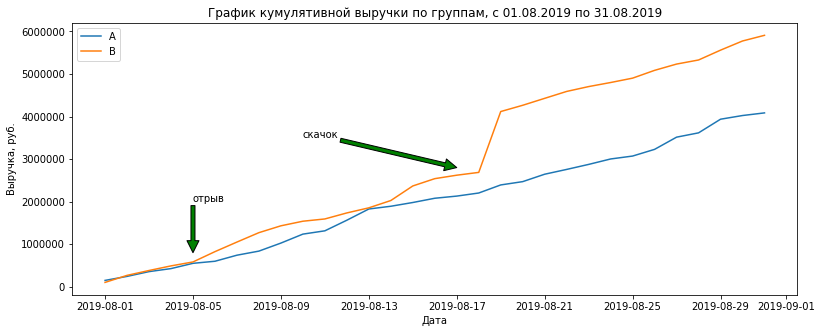

In [19]:
cumulativeRevenueA = cumulativeData.query('group == "A"')[['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData.query('group == "B"')[['date','revenue', 'orders']]


plt.figure(figsize =(13,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 
plt.title('График кумулятивной выручки по группам, с 01.08.2019 по 31.08.2019')
plt.ylabel('Выручка, руб.')
plt.xlabel('Дата')
plt.legend()
plt.show

Выручка в обеих группах растёт, но для группы В характерен резкий скачок. Это может сигнализировать о всплеске числа заказов или появлении очень дорого заказа.

### Кумулятивный средний чек

Построим график кумулятивного среднего чека по группам. Разделим кумулятивную выручку на кумулятивное число заказов:

<function matplotlib.pyplot.show(*args, **kw)>

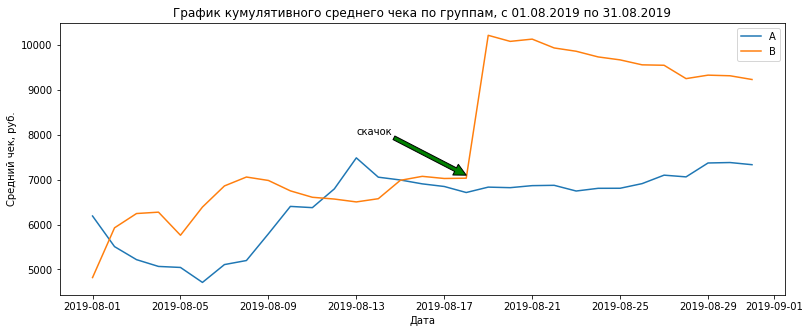

In [20]:
plt.figure(figsize =(13,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.annotate('скачок', xy=('2019-08-18', 7100), xytext=('2019-08-13', 8000),
            arrowprops=dict(facecolor='g'))
plt.title('График кумулятивного среднего чека по группам, с 01.08.2019 по 31.08.2019')
plt.ylabel('Средний чек, руб.')
plt.xlabel('Дата')
plt.legend()
plt.show

Для группы А график среднего чека становится равномерным к концу теста, для группы В наблюдаем ростс качок суммы среднего чека, но затем график становится равномерным. Вероятно, был совершена аномально-дорогая покупка, что повлияло на кумулятивный средний чек.

Построим график относительного изменения кумулятивного среднего чека в группах А и В:

<function matplotlib.pyplot.show(*args, **kw)>

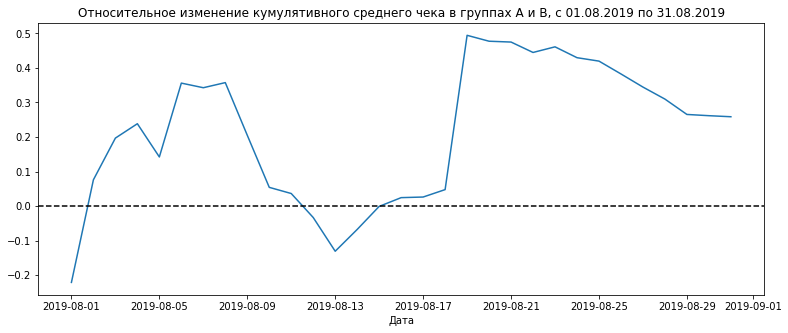

In [21]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B'])

plt.figure(figsize =(13,5))
plt.plot(
    mergedCumulativeRevenue['date'], 
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
    /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Относительное изменение кумулятивного среднего чека в группах А и В, с 01.08.2019 по 31.08.2019')
plt.xlabel('Дата')
plt.show

Резкие скачки на графике свидетельствуют о наличии выбросов в значениях среднего чека - были совершены аномальные заказы.

### Кумулятивная конверсия

Построим график кумулятивной конверсии по группам:

<function matplotlib.pyplot.show(*args, **kw)>

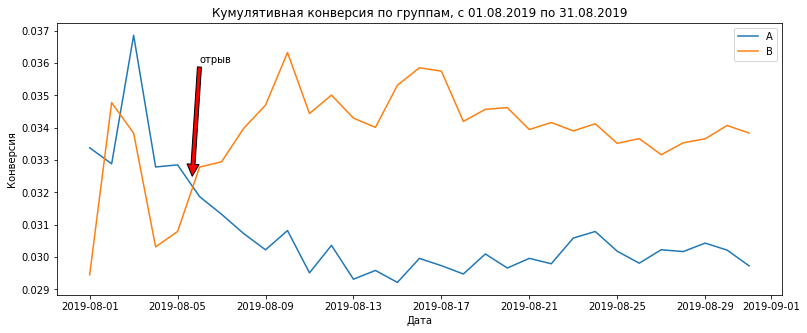

In [22]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize =(13,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.annotate('отрыв', xy=('2019-08-05 16:00:00', 0.0325), xytext=('2019-08-06', 0.036),
            arrowprops=dict(facecolor='r')) 
plt.title('Кумулятивная конверсия по группам, с 01.08.2019 по 31.08.2019')
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.legend()
plt.show

Графики несиметричные, но если в начале теста мы наблюдали рост и падение конверсии в обеих группах, то после конверсия группы А начала падение, а конверсия группы В рост. Конверсия групппы А установилась около значения(0.03) ниже, чем значение(0.034), около которого установилось значение группы В.

Построим графики относительного изменения кумулятивной конверсии группы B к группе A:

<function matplotlib.pyplot.show(*args, **kw)>

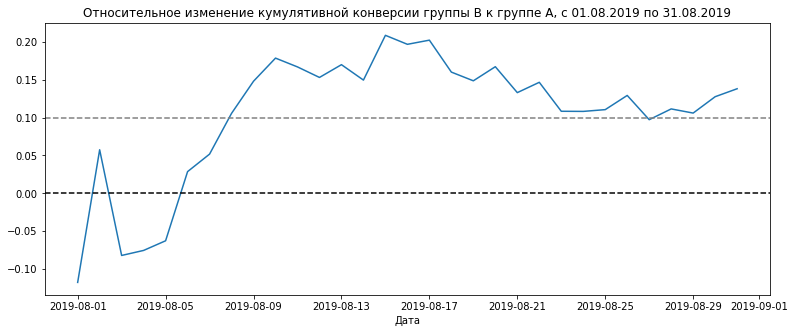

In [23]:
mergedCumulativeConversions = cumulativeDataA.merge(
    cumulativeDataB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B'])

plt.figure(figsize =(13,5))
plt.plot(
    mergedCumulativeConversions['date'], 
    (mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA'])-1
)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A, с 01.08.2019 по 31.08.2019')
plt.xlabel('Дата')
plt.show

Конверсия группы В почти с самого начала лучше относительно группы А, к концу теста прирост конверсии начинает фиксироваться около значения в 10%.

### Определение аномальных значений

Построим точечный график числа заказов по пользователям:

<function matplotlib.pyplot.show(*args, **kw)>

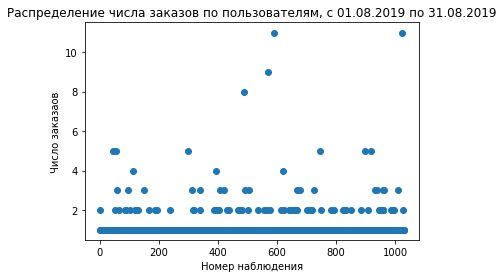

In [24]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsers.columns = ['user_id', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Распределение числа заказов по пользователям, с 01.08.2019 по 31.08.2019')
plt.xlabel('Номер наблюдения')
plt.ylabel('Число заказаов')
plt.show

Построим точечный график стоимоти заказов:

<function matplotlib.pyplot.show(*args, **kw)>

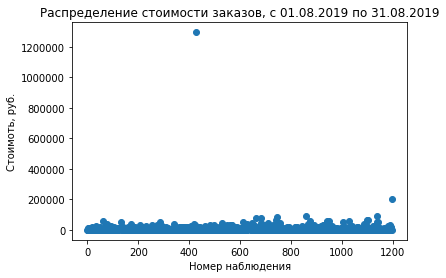

In [25]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов, с 01.08.2019 по 31.08.2019')
plt.xlabel('Номер наблюдения')
plt.ylabel('Стоимоть, руб.')
plt.show

Большинство пользователей сделали один заказ. Но число пользователей с числом заказов 2 тоже велико. Что касается стоимости заказов,большинство пользователей не выходит за стоимоть 100000(рублей?), но на графике фиксируются аномальные суммы (вероятно те самые заказы, которые мы предполагали ранее). Для определения границ аномального поведения пользователей, посчитаем 95-й и 99-й перцентели:

In [26]:
percentile = np.percentile(ordersByUsers['orders'], [95, 99])
print('Перцентели числа заказов: 95 - {:.0f}, 99 - {:.0f}'.format(percentile[0], percentile[1]))

percentile = np.percentile(orders['revenue'], [95, 99])
print('Перцентели суммы заказа: 95 - {:.0f}, 99 - {:.0f}'.format(percentile[0], percentile[1]))


Перцентели числа заказов: 95 - 2, 99 - 4
Перцентели суммы заказа: 95 - 28000, 99 - 58233


Только 5% пользователей совершают более одного заказа и только 1% пользователей совершают 4 и более заказов. ЧТо касается суммы заказа, то не более 5% процентов заказов дороже 28000 рублей и не более 1% превышают сумму в 58233 рубля.

Определим границу аномальных значений:

- сумма заказа: 50000 рублей (отсеим от 1 до 5% заказов с наибольшей стоимостью)
- число заказов: 3 (отсеим 1% пользователей с наибольшим числом заказов)

### Определение статистической значимости "сырых" данных

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 

Нулевая гипотеза - между конверсиями групп А и В нет статистически значимых различий. Альтернативная гипотеза - между конверсиями групп А и В есть статистически значимые различия.

Зададим уровень критической значимости 5%. Для оценки уровня значимости применим U-критерий Манна — Уитни.

In [27]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
)
ordersByUsersA.columns = ['user_id', 'orders']
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
)
ordersByUsersB.columns = ['user_id', 'orders']

sampleA = (
    pd.concat(
        [
            ordersByUsersA['orders'], 
            pd.Series(
                0, index=np.arange(
                    visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA)
                                  ),
                name='orders'
            )
        ],
        axis=0
    )
)
sampleB = (
    pd.concat(
        [
            ordersByUsersB['orders'], 
            pd.Series(
                0, index=np.arange(
                    visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB)
                                  ),
                name='orders'
            )
        ],
        axis=0
    )
)
alpha = 0.05
utest = stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]

print('Количество посетителей в группе А {}'.format(len(sampleA)))
print('Количество покупателей в группе А {}'.format(len(ordersByUsersA)))
print('Количество покупок в группе А {} \n'.format(sampleA.sum()))
print('Количество посетителей в группе B {}'.format(len(sampleB)))
print('Количество покупателей в группе B {}'.format(len(ordersByUsersB)))
print('Количество покупок в группе B {} \n'.format(sampleB.sum()))
print('U-test = {:.3f}'.format(utest))
if (utest < alpha):
    print('Отвергаем нулевую гипотезу, между конверсиями групп А и В есть статистически значимые различия')
else:
    print("Не получилось отвергнуть нулевую гипотезу, между конверсиями групп А и В нет статистически значимых различий")

print("Относительный прирост конверсии группы B к A {0:.1%}".format(sampleB.mean() / sampleA.mean() - 1))

Количество посетителей в группе А 18736
Количество покупателей в группе А 503
Количество покупок в группе А 557 

Количество посетителей в группе B 18916
Количество покупателей в группе B 586
Количество покупок в группе B 640 

U-test = 0.017
Отвергаем нулевую гипотезу, между конверсиями групп А и В есть статистически значимые различия
Относительный прирост конверсии группы B к A 13.8%


Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Нулевая гипотеза - между значениями среднего чека заказа групп А и В нет статистически значимых различий. Альтернативная гипотеза - между значениями среднего чека заказа групп А и В есть статистически значимые различия.

Зададим уровень критической значимости 5%. Для оценки уровня значимости применим U-критерий Манна — Уитни.

In [28]:
utest = stats.mannwhitneyu(
    orders[orders['group']=='A']['revenue'], 
    orders[orders['group']=='B']['revenue'], 
    alternative='two-sided'
)[1]
print('U-test = {:.3f}'.format(utest))
if (utest < alpha):
    print('Отвергаем нулевую гипотезу, между значениями среднего чека групп А и В есть статистически значимые различия')
else:
    print('Не получилось отвергнуть нулевую гипотезу, между значениями среднего чека групп А и В нет статистически значимых различий')
print("Относительный прирост среднего чека группы B к A {0:.1%}"
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))


U-test = 0.729
Не получилось отвергнуть нулевую гипотезу, между значениями среднего чека групп А и В нет статистически значимых различий
Относительный прирост среднего чека группы B к A 25.9%


### Определение статистической значимости "очищенных" данных

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

Нулевая гипотеза - между конверсиями групп А и В нет статистически значимых различий. Альтернативная гипотеза - между конверсиями групп А и В есть статистически значимые различия.

Зададим уровень критической значимости 5%. Для оценки уровня значимости применим U-критерий Манна — Уитни.

In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['user_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0
)
utest = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered,alternative='two-sided')[1]
print('U-test = {:.3f}'.format(utest))
if (utest < alpha):
    print('Отвергаем нулевую гипотезу, между конверсиями групп А и В есть статистически значимые различия')
else:
    print('Не получилось отвергнуть нулевую гипотезу, между конверсиями групп А и В нет статистически значимых различий')

print(
    'Относительный прирост конверсии группы B к A {0:.1%}'
    .format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

U-test = 0.011
Отвергаем нулевую гипотезу, между конверсиями групп А и В есть статистически значимые различия
Относительный прирост конверсии группы B к A 15.8%


Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Нулевая гипотеза - между значениями среднего чека заказа групп А и В нет статистически значимых различий. Альтернативная гипотеза - между значениями среднего чека заказа групп А и В есть статистически значимые различия.

Зададим уровень критической значимости 5%. Для оценки уровня значимости применим U-критерий Манна — Уитни.

In [30]:
utest = stats.mannwhitneyu(
    orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(
                orders['visitor_id'].isin(abnormalUsers)
            )
        )
    ]['revenue'],
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(
                orders['visitor_id'].isin(abnormalUsers)
            )
        )
    ]['revenue'], alternative='two-sided')[1]
print('U-test = {:.3f}'.format(utest))
if (utest < alpha):
    print('Отвергаем нулевую гипотезу, между значениями среднего чека групп А и В есть статистически значимые различия')
else:
    print('Не получилось отвергнуть нулевую гипотезу, между значениями среднего чека групп А и В нет статистически значимых различий')
print("Относительный прирост среднего чека группы B к A {0:.1%}"
      .format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

U-test = 0.819
Не получилось отвергнуть нулевую гипотезу, между значениями среднего чека групп А и В нет статистически значимых различий
Относительный прирост среднего чека группы B к A 2.4%


**Вывод:**
После очистки данных различия в конверсии групп А и В имеет статистическое значение. Относительный прирост конверсии группы В к конверсии к группе составил 15.8%. Между значениями среднего чека групп А и В нет статистически значимых различий. Относительный прирост среднего чека группы B к A 2.4%

Можно сделать вывод, что пользователи группы В покупают чаще, но средний чек не отличается от покупателей из группы А. Полученный результат имеет статистическое значение, тест следует остановить и зафиксировать победу группы В.

## Общий вывод

Для увеличения выручки крупного интернет-магазина подготовленный список гипотез приоритизирован фреймворками ICE и RICE. Разница в приритете гипотез различными фреймворками объясняется учетом параметра Reach.

**Наибольший приоритет присвоен гипотезе 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**.

Временной период проведения A/B-теста с 1 по 31 августа 2019 года. Данные содержат информацию о заказах и о посещении сайта по группам. В данных о заказах обнаружено 58 покупателей, попавшие в обе группы тестирования. Всего в тестировании зафиксировано 1031 уникальный покупатель.

Для определения успешности теста построены графики кумулятивных метрик по группам тестирования. На графике кумулятивной выручки видно, что выручка в обеих группах растёт, но для группы В характерен резкий скачок. Это сигнализирует о всплеске числа заказов или появлении очень дорого заказа.

Для группы А график среднего чека становится равномерным к концу теста, для группы В наблюдаем ростс качок суммы среднего чека, но затем график становится равномерным. Вероятно, был совершена аномально-дорогая покупка, что повлияло на кумулятивный средний чек.

Резкие скачки на графике относительного изменения средного чека группы В к группе А свидетельствуют о наличии выбросов в значениях среднего чека - были совершены аномальные заказы.

Графики кумулятивной конверсии по группам тестирования несиметричные, но если в начале теста мы наблюдали рост и падение конверсии в обеих группах, то после конверсия группы А начала падение, а конверсия группы В рост. Конверсия групппы А установилась около значения(0.03) ниже, чем значение(0.034), около которого установилось значение группы В.

Конверсия группы В почти с самого начала лучше относительно группы А, к концу теста прирост конверсии начинает фиксироваться около значения в 10%.

Чтобы определить исключить аномальное поведение пользователей, построены точечные графики числа покупок на пользователя и суммы заказа. Большинство пользователей сделали один заказ. Но число пользователей с числом заказов 2 тоже велико. Что касается стоимости заказов, большинство пользователей не выходит за стоимоть 100000 рублей. Граница аномальных значений:

- сумма заказа: 50000 рублей (отсеим от 1 до 5% заказов с наибольшей стоимостью)
- число заказов: 3 (отсеим 1% пользователей с наибольшим числом заказов)

Результаты проверки статистической значимости для "сырых" данных:

Между конверсиями групп А и В есть статистически значимые различия, относительный прирост конверсии группы B к A 15.8%. Между значениями среднего чека групп А и В нет статистически значимых различий, относительный прирост среднего чека группы B к A 25.9%.

Результаты проверки статистической значимости для "очищенных" данных:

Между конверсиями групп А и В есть статистически значимые различия, Относительный прирост конверсии группы B к A 15.8%. Между значениями среднего чека групп А и В нет статистически значимых различий, относительный прирост среднего чека группы B к A 2.4%.

Можно сделать вывод, что пользователи группы В покупают чаще, но средний чек не отличается от покупателей из группы А. Полученный результат имеет статистическое значение, **тест следует остановить и зафиксировать победу группы В**.